**Predicting NFL Scores**

Welcome to our predicting NFL scores ECS 171 project. The purpose of this project is to build a model that tries to predict the amount of points an NFL team will score, and then compare that data to what actually happens in the real world!

Let's start with basic imports and reading in the data set.
Cleaning up our dataset happens below.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
    
oRaw = pd.read_csv("nfl_pass_rush_receive_raw_data.csv")
df = pd.DataFrame()
#Lambda function to print correct score

def categorise(row):  
    if row['team'] == row['vis_team']:
        return row['vis_score']
    else:
        return row['home_score']
oRaw['score'] = oRaw.apply(lambda row: categorise(row), axis=1)

oPass = oRaw[oRaw['pass_att'] > 1]
oPassG = oPass.groupby(['game_id', 'team'])
df['pass_yds'] = oPassG['pass_yds'].sum()
df['pass_cmp'] = oPassG['pass_cmp'].sum()
df['pass_att'] = oPassG['pass_att'].sum()
df['pass_td'] = oPassG['pass_td'].sum()
df['pass_int'] = oPassG['pass_int'].sum()
df['pass_yds/att'] = df['pass_yds']/df['pass_att']
df['pass_yds/cmp'] = df['pass_yds']/df['pass_cmp']
df['pass_sacked'] = oPassG['pass_sacked'].sum()
df['pass_sacked_yds'] = oPassG['pass_sacked_yds'].sum()
df['pass_blitzed'] = oPassG['pass_blitzed'].sum()
df['pass_hurried'] = oPassG['pass_hurried'].sum()
df['fumbles_lost'] = oPassG['fumbles_lost'].sum()
oRawDrop = oRaw.drop_duplicates(subset=['game_id', 'team'])
oHelp = oRawDrop.groupby(['game_id', 'team'])
df['score'] = oHelp['score'].sum()
oRush = oRaw[oRaw['rush_att'] > 1]
oRushG = oRush.groupby(['game_id', 'team'])
df['rush_yds'] = oRushG['rush_yds'].sum()
df['rush_att'] = oRushG['rush_att'].sum()
df['rush_td'] = oRushG['rush_td'].sum()
oRec = oRaw[oRaw['rec']>1]
oRecG = oRec.groupby(['game_id','team'])
df['rec_yds'] = oRecG['rec_yds'].sum()
df['rec_td'] = oRecG['rec_td'].sum()
df['totalYds'] = df['pass_yds'] + df['rush_yds']
df = df.reset_index()
t1 = df.iloc[1::2]
t2 = df.iloc[::2]
d = {}
for x in t1.keys():
    if "game_id" not in x and "team" not in x:
        d[x] = "o"+x
t1 = t1.rename(columns=d)
t2 = t2.rename(columns=d)
i1 = t1.index.values.tolist()
i2 = t2.index.values.tolist()
t1.index=i2
t2.index=i1
t1 = t1.drop(columns=['game_id','team'])
t2 = t2.drop(columns=['game_id','team'])
t3 = pd.concat([t1,t2])
df = pd.concat([df,t3],axis=1)
df = df.drop(columns=['oscore'])
print(df)
#t5 = pd.concat([t3,t4])
#print(t5)
#print(df['opass_yds'])

           game_id team  pass_yds  pass_cmp  pass_att  pass_td  pass_int  \
0     201909050chi  CHI       228        26        45        0         1   
1     201909050chi  GNB       203        18        30        1         0   
2     201909080car  CAR       239        25        38        0         1   
3     201909080car  LAR       186        23        39        1         1   
4     201909080cle  CLE       285        25        38        1         3   
...            ...  ...       ...       ...       ...      ...       ...   
1935  202211130sfo  SFO       240        19        28        0         0   
1936  202211130tam  SEA       275        23        33        2         0   
1937  202211130tam  TAM       258        22        29        2         1   
1938  202211140phi  PHI       175        17        26        2         1   
1939  202211140phi  WAS       211        17        29        0         1   

      pass_yds/att  pass_yds/cmp  pass_sacked  ...  opass_sacked_yds  \
0         5.066

A quick print of our data shows that our data has not been standardized or normalized.

In [10]:
#dont mind me, just changing na's to 0, since all NA's means none of the stat was achieved in the game
#totally did not figure this out until breaking my model so many times..
df = df.fillna(0)

len(df)
#1940 Rows - meaning 1940/2 games analyzed for a total of 970 games. 
#1940 observations in total. No data is missing.

print(df)
#COLUMN DESCRIPTIONS
#game_id = game identification
#team = team that played
#pass_yds = number of passing yards in game by team
#pass_cmp = number of passes completed in game
#pass_att = number of passes tried
#pass_tds = number of passes that led to a touchdown
#pass_int = number of passes that were intercepted
#pass_yds/att = pass_yds/att
#pass_yds/cmp = pass_yds/cmp "air yardage"
#pass_sacked = amount of time the qb was sacked
#pass_sacked_yds = amount of yards lost by the qb being sacked
#pass_blitzed = amount of times the qb was blitzed
#pass_hurried = amount of times the qb was hurried into making a throw
#rush_yds = amount of rushing yards in game by team
#rush_att = amount of rush attempts in a game
#rush_td = amount of rushes leading to tds
#rec_yds = amount of receiving yards in game by team
#rec_td = amount of receptions leading to a touchdown
#fumbles_lost = amount of fumbles that were recovered by the opposing team
#totalYds = total amount of offense yardage by team

#o columns are just the same statistics, for the enemy team of the same game.

           game_id team  pass_yds  pass_cmp  pass_att  pass_td  pass_int  \
0     201909050chi  CHI       228        26        45        0         1   
1     201909050chi  GNB       203        18        30        1         0   
2     201909080car  CAR       239        25        38        0         1   
3     201909080car  LAR       186        23        39        1         1   
4     201909080cle  CLE       285        25        38        1         3   
...            ...  ...       ...       ...       ...      ...       ...   
1935  202211130sfo  SFO       240        19        28        0         0   
1936  202211130tam  SEA       275        23        33        2         0   
1937  202211130tam  TAM       258        22        29        2         1   
1938  202211140phi  PHI       175        17        26        2         1   
1939  202211140phi  WAS       211        17        29        0         1   

      pass_yds/att  pass_yds/cmp  pass_sacked  ...  opass_sacked_yds  \
0         5.066

**Distribution Analysis + Extra Fun Plots**

array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

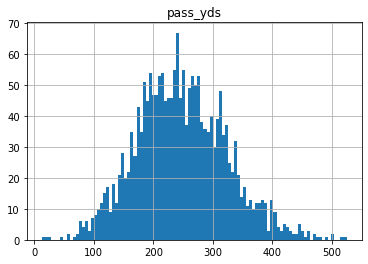

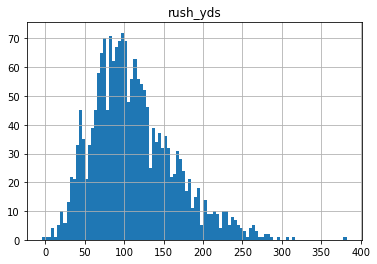

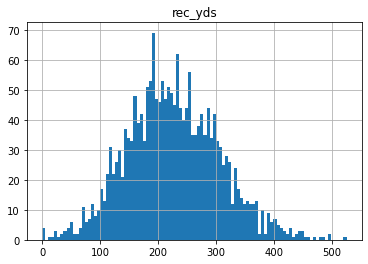

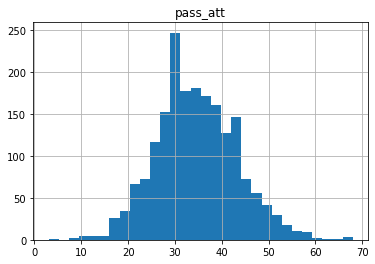

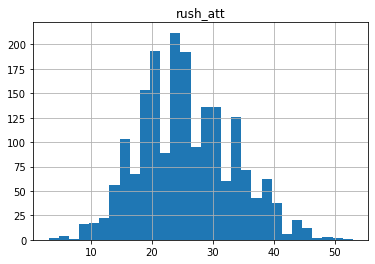

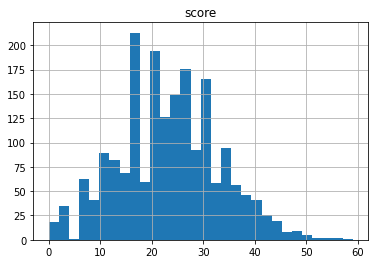

In [11]:
df.hist('pass_yds',bins=100)
df.hist('rush_yds',bins=100)
df.hist('rec_yds',bins=100)
df.hist('pass_att',bins=30)
df.hist('rush_att',bins=30)
df.hist('score',bins=30)

As we can see, from these distributions, pass, rush, and rec yards/att are all normal. We could have choose to use some sort of standardization, but chose to still normalize. I don't think a standardization would have worked as some of our data does not have a bell-curve distribution (as seen below). But the reason for this choice of normalization, is because we plan to use a Neural Network to do the scores prediction at the end. Let's do a little more data plotting before we finally normalize the data. 

array([[<AxesSubplot:title={'center':'pass_hurried'}>]], dtype=object)

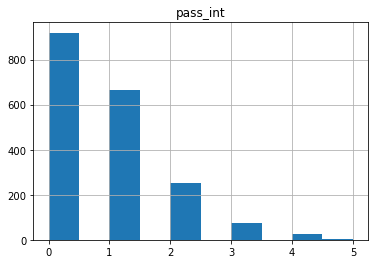

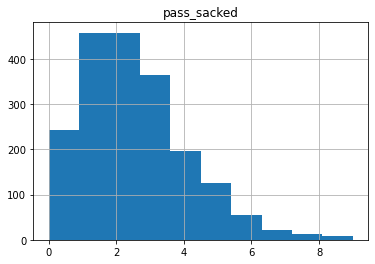

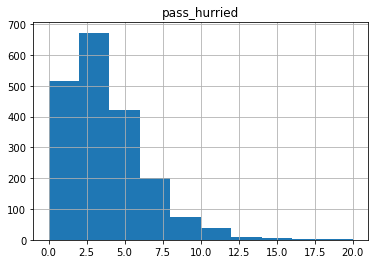

In [12]:
df.hist('pass_int',bins=10)
df.hist('pass_sacked',bins=10)
df.hist('pass_hurried',bins=10)

<AxesSubplot:xlabel='pass_sacked', ylabel='pass_yds'>

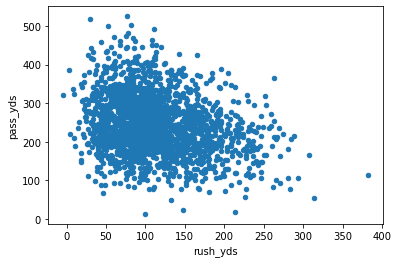

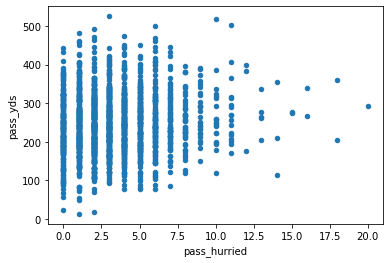

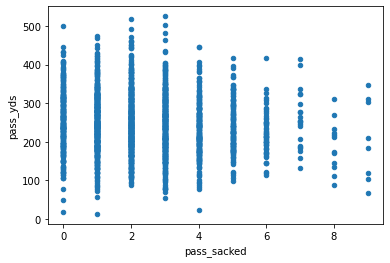

In [13]:
df.plot(y="pass_yds",x="rush_yds",kind="scatter")
#cool inverse correlation between pass yards and rush yards, more pass yards = less ryd and inverse is true.

df.plot(y="pass_yds",x="pass_hurried",kind="scatter")
#pass hurries seems to have no effect on amount of pass yards!

df.plot(y="pass_yds",x="pass_sacked",kind="scatter")
#but we can clearly see that sacks do.

In [15]:
column_headers = list(df.columns.values)
column_headers.remove('score')
column_headers.remove('team')
column_headers.remove('game_id')
scaler = MinMaxScaler()
df= df.fillna(0)
normdf = pd.DataFrame(scaler.fit_transform(df.drop(['score','team','game_id'],axis=1)), columns=column_headers)
print(normdf)


      pass_yds  pass_cmp  pass_att   pass_td  pass_int  pass_yds/att  \
0     0.419922  0.543478  0.646154  0.000000       0.2      0.275822   
1     0.371094  0.369565  0.415385  0.166667       0.0      0.405272   
2     0.441406  0.521739  0.538462  0.000000       0.2      0.368935   
3     0.337891  0.478261  0.553846  0.166667       0.2      0.253173   
4     0.531250  0.521739  0.538462  0.166667       0.6      0.461113   
...        ...       ...       ...       ...       ...           ...   
1935  0.443359  0.391304  0.384615  0.000000       0.0      0.542699   
1936  0.511719  0.478261  0.461538  0.333333       0.0      0.524569   
1937  0.478516  0.456522  0.400000  0.333333       0.2      0.567456   
1938  0.316406  0.347826  0.353846  0.333333       0.2      0.402538   
1939  0.386719  0.347826  0.400000  0.000000       0.2      0.444045   

      pass_yds/cmp  pass_sacked  pass_sacked_yds  pass_blitzed  ...  \
0         0.201061     0.555556         0.253165      0.472222  

From here, all there's left to do is build a model that takes in all of these criteria and predicts the total points scored. Then we can test with against the real life data of the upcoming weeks!

**Building our first model!**

For our first model, we used a Keras NN.


In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

X = normdf
y = df['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
print(np.any(np.isnan(X_test)))
print(np.any(np.isnan(y_test)))
model = Sequential()
model.add(Dense(units = 16,activation = 'relu', input_dim= 36))
model.add(Dense(units = 1,activation = 'relu'))
model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
model.fit(X_train, y_train, batch_size = 1, epochs = 100)
yhat = model.predict(X_test)

False
False
Epoch 1/100
1552/1552 [==============================] - 1s 710us/step - loss: 8.2242
Epoch 2/100
1552/1552 [==============================] - 1s 672us/step - loss: 4.7306
Epoch 3/100
1552/1552 [==============================] - 1s 713us/step - loss: 3.8501
Epoch 4/100
1552/1552 [==============================] - 1s 678us/step - loss: 3.5445
Epoch 5/100
1552/1552 [==============================] - 1s 883us/step - loss: 3.4093
Epoch 6/100
1552/1552 [==============================] - 1s 656us/step - loss: 3.3423
Epoch 7/100
1552/1552 [==============================] - 1s 663us/step - loss: 3.2772
Epoch 8/100
1552/1552 [==============================] - 1s 661us/step - loss: 3.2402
Epoch 9/100
1552/1552 [==============================] - 1s 657us/step - loss: 3.2066
Epoch 10/100
1552/1552 [==============================] - 1s 658us/step - loss: 3.1966
Epoch 11/100
1552/1552 [==============================] - 1s 663us/step - loss: 3.1918
Epoch 12/100
1552/1552 [================

1552/1552 [==============================] - 1s 682us/step - loss: 3.0877
Epoch 96/100
1552/1552 [==============================] - 1s 674us/step - loss: 3.0708
Epoch 97/100
1552/1552 [==============================] - 1s 685us/step - loss: 3.0894
Epoch 98/100
1552/1552 [==============================] - 1s 694us/step - loss: 3.0866
Epoch 99/100
1552/1552 [==============================] - 1s 679us/step - loss: 3.0896
Epoch 100/100
13/13 [==============================] - 0s 691us/step


49/49 [==============================] - 0s 634us/step
training mse: 15.983687610731334
testing mse: 14.039012634534483


<AxesSubplot:xlabel='y_test', ylabel='yhat'>

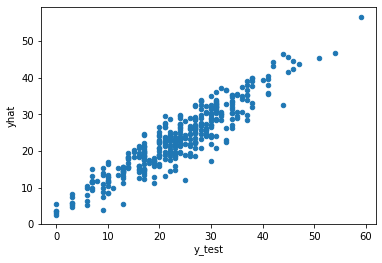

In [17]:
from sklearn.metrics import classification_report, mean_squared_error
import matplotlib.pyplot as plt
comp = pd.DataFrame(yhat)
comp['y_test'] = y_test.values
comp.columns = ['yhat','y_test']
print("training mse: " + str(mean_squared_error(model.predict(X_train),y_train)))
print("testing mse: "  + str(mean_squared_error(yhat,y_test)))
comp.plot(x = 'y_test', y = 'yhat',kind="scatter")


**Second Model**
Let's try another model, but this time we're going to add more layers.

In [18]:
model2 = Sequential()
model2.add(Dense(units = 16,activation = 'relu', input_dim= 36))
model2.add(Dense(units = 16,activation = 'relu'))
model2.add(Dense(units = 16,activation = 'relu'))
model2.add(Dense(units = 1,activation = 'relu'))
model2.compile(optimizer = 'adam', loss = 'mean_absolute_error')
model2.fit(X_train, y_train, batch_size = 1, epochs = 100)
yhat2 = model2.predict(X_test)

Epoch 1/100
1552/1552 [==============================] - 1s 753us/step - loss: 7.5552
Epoch 2/100
1552/1552 [==============================] - 1s 920us/step - loss: 3.6745
Epoch 3/100
1552/1552 [==============================] - 1s 703us/step - loss: 3.4050
Epoch 4/100
1552/1552 [==============================] - 1s 695us/step - loss: 3.3462
Epoch 5/100
1552/1552 [==============================] - 1s 704us/step - loss: 3.3110
Epoch 6/100
1552/1552 [==============================] - 1s 781us/step - loss: 3.2624
Epoch 7/100
1552/1552 [==============================] - 1s 773us/step - loss: 3.2578
Epoch 8/100
1552/1552 [==============================] - 1s 718us/step - loss: 3.2325
Epoch 9/100
1552/1552 [==============================] - 1s 804us/step - loss: 3.1835
Epoch 10/100
1552/1552 [==============================] - 1s 749us/step - loss: 3.1821
Epoch 11/100
1552/1552 [==============================] - 1s 791us/step - loss: 3.1755
Epoch 12/100
1552/1552 [============================

1552/1552 [==============================] - 1s 764us/step - loss: 2.9446
Epoch 96/100
1552/1552 [==============================] - 1s 707us/step - loss: 2.9512
Epoch 97/100
1552/1552 [==============================] - 1s 707us/step - loss: 2.9602
Epoch 98/100
1552/1552 [==============================] - 1s 700us/step - loss: 2.9409
Epoch 99/100
1552/1552 [==============================] - 1s 896us/step - loss: 2.9904
Epoch 100/100
13/13 [==============================] - 0s 2ms/step


49/49 [==============================] - 0s 647us/step
training mse: 15.25145752823255
testing mse: 15.28878996391994
           game_id team  pass_yds  pass_cmp  pass_att  pass_td  pass_int  \
12    201909080mia  BAL       379        23        26        6         0   
121   201909290ram  TAM       385        28        41        4         1   
135   201910060htx  HOU       426        28        33        5         0   
239   201910270sfo  SFO       175        18        22        2         1   
527   202001120kan  KAN       321        23        35        5         0   
981   202012250nor  NOR       319        21        28        0         2   
1012  202101030buf  BUF       388        24        38        4         2   
1266  202110240nwe  NWE       386        27        40        2         0   
1530  202112260dal  DAL       400        30        42        5         0   
1575  202201020sea  SEA       236        20        29        4         0   
1584  202201080phi  DAL       295        21   

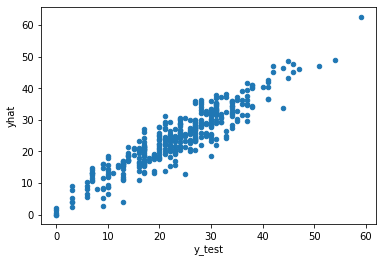

In [19]:
comp2 = pd.DataFrame(yhat2)
comp2['y_test'] = y_test.values
comp2.columns = ['yhat','y_test']
print("training mse: " + str(mean_squared_error(model2.predict(X_train),y_train)))
print("testing mse: "  + str(mean_squared_error(yhat2,y_test)))
comp2.plot(x = 'y_test', y = 'yhat',kind="scatter")
print(df[df['score'] > 50])

In [20]:
#From here, we're going to build the input generator. The input generator just generates the same stats format from the last four weeks.

import pandas as pd
oRaw = pd.read_csv('last4.csv')
df2= pd.DataFrame()
#Lambda function to print correct score

def categorise(row):  
    if row['team'] == row['vis_team']:
        return row['vis_score']
    else:
        return row['home_score']
oRaw['score'] = oRaw.apply(lambda row: categorise(row), axis=1)

oPass = oRaw[oRaw['pass_att'] > 1]
oPassG = oPass.groupby(['game_id', 'team'])
df2['pass_yds'] = oPassG['pass_yds'].sum()
df2['pass_cmp'] = oPassG['pass_cmp'].sum()
df2['pass_att'] = oPassG['pass_att'].sum()
df2['pass_td'] = oPassG['pass_td'].sum()
df2['pass_int'] = oPassG['pass_int'].sum()
df2['pass_yds/att'] = df2['pass_yds']/df2['pass_att']
df2['pass_yds/cmp'] = df2['pass_yds']/df2['pass_cmp']
df2['pass_sacked'] = oPassG['pass_sacked'].sum()
df2['pass_sacked_yds'] = oPassG['pass_sacked_yds'].sum()
df2['pass_blitzed'] = oPassG['pass_blitzed'].sum()
df2['pass_hurried'] = oPassG['pass_hurried'].sum()
df2['fumbles_lost'] = oPassG['fumbles_lost'].sum()
df2['score'] = oPassG['score'].sum()
oRush = oRaw[oRaw['rush_att'] > 1]
oRushG = oRush.groupby(['game_id', 'team'])
df2['rush_yds'] = oRushG['rush_yds'].sum()
df2['rush_att'] = oRushG['rush_att'].sum()
df2['rush_td'] = oRushG['rush_td'].sum()
oRec = oRaw[oRaw['rec']>1]
oRecG = oRec.groupby(['game_id','team'])
df2['rec_yds'] = oRecG['rec_yds'].sum()
df2['rec_td'] = oRecG['rec_td'].sum()
df2['totalYds'] = df2['pass_yds'] + df2['rush_yds']
df2 = df2.reset_index()
t1 = df2.iloc[1::2]
t2 = df2.iloc[::2]
d = {}
for x in t1.keys():
    if "game_id" not in x and "team" not in x:
        d[x] = "o"+x
t1 = t1.rename(columns=d)
t2 = t2.rename(columns=d)
i1 = t1.index.values.tolist()
i2 = t2.index.values.tolist()
t1.index=i2
t2.index=i1
t1 = t1.drop(columns=['game_id','team'])
t2 = t2.drop(columns=['game_id','team'])
t3 = pd.concat([t1,t2])
df2 = pd.concat([df2,t3],axis=1)
df2 = df2.drop(columns=['oscore'])

count = df2['team'].value_counts()
df2 = df2.drop(['score','game_id'],axis=1)
df2 = df2.groupby('team').sum()
df2 = pd.concat([df2,count],axis=1)
df2.iloc[:,:] = df2.iloc[:,:].div(df2.team, axis=0)
df2 = df2.drop('team',axis=1)
print(df2)

       pass_yds   pass_cmp   pass_att   pass_td  pass_int  pass_yds/att  \
ARI  220.250000  24.750000  36.250000  1.250000  0.750000      6.078523   
ATL  155.000000  14.750000  24.500000  1.000000  0.500000      6.329674   
BAL  198.666667  17.333333  29.000000  0.666667  0.333333      6.772096   
BUF  246.250000  22.250000  36.500000  1.000000  1.250000      6.755984   
CAR  158.000000  14.750000  24.500000  0.750000  1.000000      6.696910   
CHI  155.500000  14.250000  23.500000  1.750000  0.750000      6.797143   
CIN  284.333333  23.666667  35.666667  2.000000  0.666667      7.918233   
CLE  248.666667  24.333333  37.666667  1.666667  0.333333      6.545086   
DAL  277.666667  24.666667  35.333333  2.333333  1.333333      8.231401   
DEN  225.000000  21.333333  36.000000  0.666667  0.333333      6.278136   
DET  194.500000  18.250000  28.750000  1.250000  0.250000      6.794699   
GNB  248.750000  19.500000  31.750000  2.250000  1.250000      8.476989   
HOU  234.333333  22.33333

In [21]:
def createPreds(schedule):
    teams = pd.DataFrame()
    for x in schedule:
        row1 = df2.loc[[x[0]]]
        row2 = df2.loc[[x[1]]]
        row2.iloc[:,18:36] = row1.iloc[:,0:18].values
        row1.iloc[:,18:36] = row2.iloc[:,0:18].values
        teams = pd.concat([teams,row1])
        teams = pd.concat([teams,row2])
    teams = teams.reset_index()
    teams = teams.drop(['index'],axis=1)
    aSM = pd.DataFrame(scaler.transform(teams), columns=column_headers)
    aSM = np.asarray(aSM).astype('float32') 
    projPoints = model.predict(aSM)
    c = 0
    for x in schedule:
        print(x[0] + " will score " + str(projPoints[c]) + " points.\n")
        c = c+1
        print(x[1] + " will score " + str(projPoints[c]) + " points.\n\n")
        c = c+1

createPreds([['BUF','NWE'],['PIT','ATL'],['DEN','BAL'],['GNB','CHI'],['JAX','DET'],['CLE','HOU'],['NYJ','MIN'],['WAS','NYG'],['TEN','PHI'],['SEA','LAR'],['MIA','SFO'],['KAN','CIN'],['LAC','LVR'],['IND','DAL'],['NOR','TAM']])

1/1 [==============================] - 0s 44ms/step
BUF will score [22.117437] points.

NWE will score [16.98433] points.


PIT will score [22.326149] points.

ATL will score [18.58692] points.


DEN will score [13.815851] points.

BAL will score [21.288742] points.


GNB will score [23.713558] points.

CHI will score [26.488953] points.


JAX will score [23.526943] points.

DET will score [25.048878] points.


CLE will score [24.365719] points.

HOU will score [14.2601595] points.


NYJ will score [21.352913] points.

MIN will score [17.038803] points.


WAS will score [18.798656] points.

NYG will score [24.704603] points.


TEN will score [20.393543] points.

PHI will score [26.739414] points.


SEA will score [27.148766] points.

LAR will score [16.677668] points.


MIA will score [28.469872] points.

SFO will score [25.41791] points.


KAN will score [27.3815] points.

CIN will score [32.352425] points.


LAC will score [20.496307] points.

LVR will score [27.563728] points.


IND

In the attached excel file, we see how our model fares with this week's NFL games. (Week 13!)